# Natural Gas Price Extrapolation and Estimation

##### Role: 
- You are a Quantitative Researcher on a commodity trading desk at J.P. Morgan.
- You support the desk by analyzing market data to improve the pricing accuracy of new trading instruments — in this case, natural gas storage contracts.

##### Business Context:
- Alex, the VP on your desk, wants to expand into trading natural gas storage contracts. These contracts allow producers, refiners, and trading firms to store physical natural gas to exploit seasonal price differentials, for example, buying gas in summer when prices are lower, storing it, and selling it in winter when demand (and prices) typically rise.

- However, to price these contracts properly, the desk needs:
1. Clean historical data to understand seasonal patterns.
2. A forecast to estimate prices for the next year — especially useful when negotiating longer-term storage contracts.

- Currently, the desk uses an external feed providing monthly snapshots of natural gas prices at the end of each month.
- This data is stored in a time series database and covers:
1. Historical prices from 31st October 2020 to 30th September 2024.
2. Limited forward pricing for about 18 months ahead.

- Your Task:
1. Download and load the monthly natural gas price CSV.
2. Analyze the time series for trends and seasonal patterns — for example, how prices vary month-to-month due to heating demand.

- Build a model to:
1. Interpolate missing prices for any historical date.
2. Extrapolate an indicative price for any future date up to one year ahead.
3. Write a Python function that takes any date as input and returns an estimated natural gas price.

- Visualize:
1. The historical prices.
2. The seasonality effect.
3. The extrapolated forecast for the next year.

- Practical Application:
- The output of your model will help the trading desk:
1. Price storage contracts more confidently.
2. Identify profitable periods for injection (buy & store) and withdrawal (sell).
3. Better manage supply risks and seasonal demand swings.

- Technical Requirements:
1. Use Python (Jupyter Notebook or a Python script).
2. Use libraries like pandas, numpy, matplotlib, scikit-learn or statsmodels.
3. Keep the model simple and explainable — for example, linear regression plus a seasonal component.

# Required libraries


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('Nat_Gas.csv')
df.head(5)

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [8]:
# Check data pipeline
print("\n--- Data Info ---")
print(df.info())

df['Dates'] = df['Dates'].astype(str).str.strip()

# STEP 4: Parse the 'Dates' column correctly
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y', errors='coerce')

# STEP 5: Check data info
print("\n--- Data Info ---")
print(df.info())

# STEP 6: Check for missing values
print("\n--- Missing Values ---")
print(df.isnull().sum())

# STEP 7: Sort by date (good practice for time series)
df = df.sort_values('Dates').reset_index(drop=True)



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes
None

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dates   48 non-null     datetime64[ns]
 1   Prices  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 900.0 bytes
None

--- Missing Values ---
Dates     0
Prices    0
dtype: int64


# Trend and Seasonality Analysis

       Dates  Prices  Month  Year
0 2020-10-31    10.1     10  2020
1 2020-11-30    10.3     11  2020
2 2020-12-31    11.0     12  2020
3 2021-01-31    10.9      1  2021
4 2021-02-28    10.9      2  2021


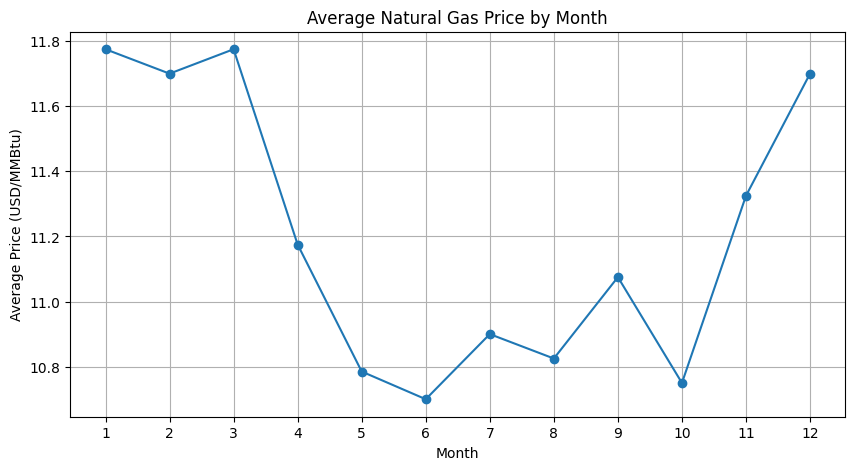

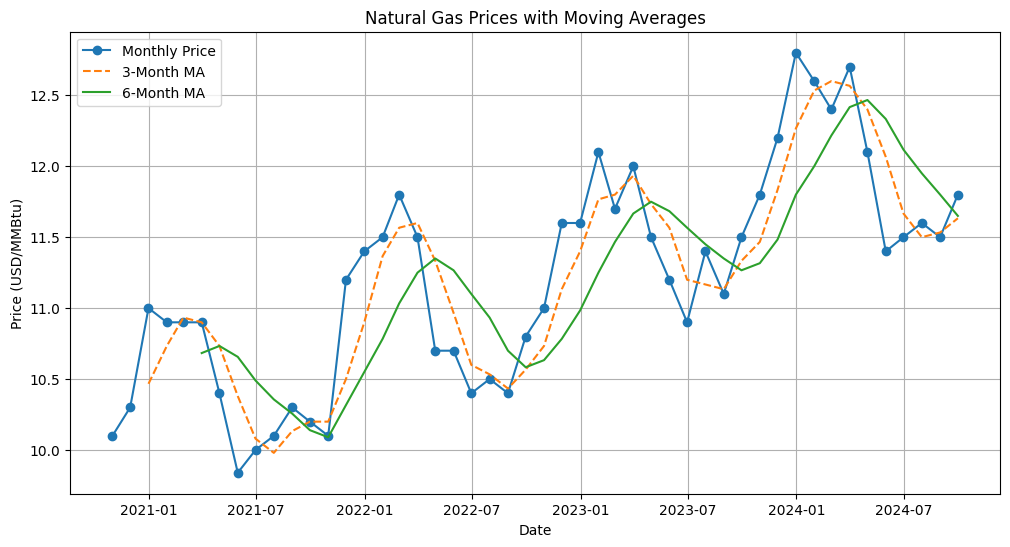

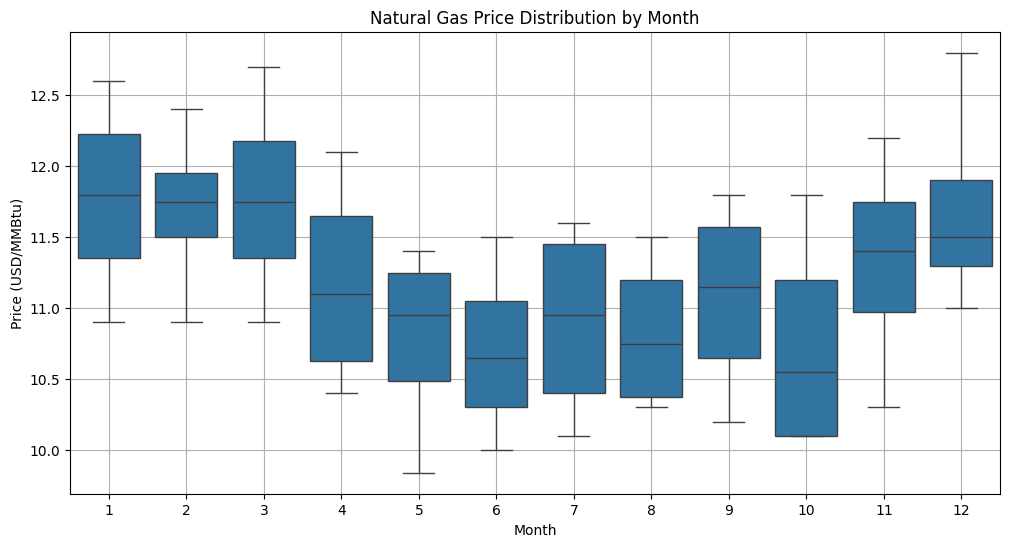

In [11]:
import seaborn as sns

# 1️⃣ Add a Month column
df['Month'] = df['Dates'].dt.month
df['Year'] = df['Dates'].dt.year

print(df.head())

# 2️⃣ Visualize seasonality: Average price by month
monthly_avg = df.groupby('Month')['Prices'].mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title('Average Natural Gas Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price (USD/MMBtu)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

# 3️⃣ Plot moving averages to show trend smoothness
# Example: 3-month and 6-month moving average
df['MA_3'] = df['Prices'].rolling(window=3).mean()
df['MA_6'] = df['Prices'].rolling(window=6).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Dates'], df['Prices'], marker='o', linestyle='-', label='Monthly Price')
plt.plot(df['Dates'], df['MA_3'], linestyle='--', label='3-Month MA')
plt.plot(df['Dates'], df['MA_6'], linestyle='-', label='6-Month MA')
plt.title('Natural Gas Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD/MMBtu)')
plt.legend()
plt.grid(True)
plt.show()

# 4️⃣ Optional: Monthly boxplots to see price spread by month
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Prices', data=df)
plt.title('Natural Gas Price Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Price (USD/MMBtu)')
plt.grid(True)
plt.show()


# Seasonal ARIMA Pipeline

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Check series
# ARIMA needs the series to be stationary
result = adfuller(df['Prices'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("✅ Series is stationary (good for ARIMA)")
else:
    print("⚠️ Series is NOT stationary (may need differencing)")

ADF Statistic: 0.21807686170000096
p-value: 0.9732574388448694
⚠️ Series is NOT stationary (may need differencing)


In [13]:
# Use 'Dates' as index
df.set_index('Dates', inplace=True)

# Fit SARIMA
model = SARIMAX(df['Prices'],
                order=(1,1,1),          # ARIMA(p,d,q)
                seasonal_order=(1,1,1,12),  # SARIMA(P,D,Q,s)
                enforce_stationarity=False,
                enforce_invertibility=False)

sarima_result = model.fit(disp=False)
print(sarima_result.summary())

c:\Users\user\Desktop\QuantitativeResearch\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\user\Desktop\QuantitativeResearch\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\user\Desktop\QuantitativeResearch\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                             Prices   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   1.581
Date:                            Fri, 11 Jul 2025   AIC                              6.838
Time:                                    17:25:02   BIC                             12.061
Sample:                                10-31-2020   HQIC                             7.972
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4533      0.301     -1.505      0.132      -1.044       0.137
ma.L1         -0.5152      0.344   

C:\Users\user\AppData\Local\Temp\ipykernel_11520\4275615154.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='M')


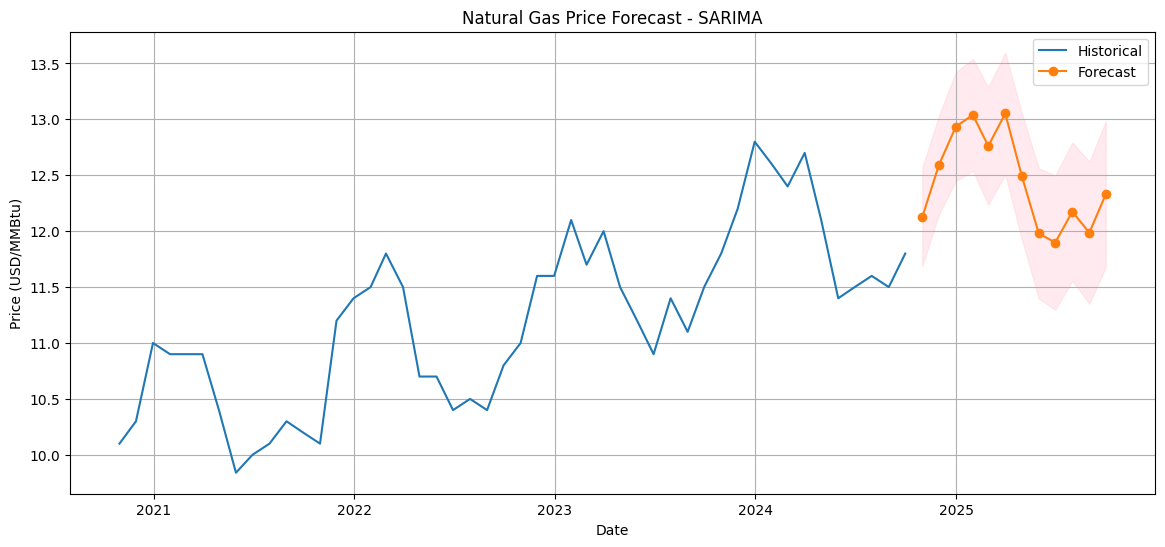

In [14]:
# Forecast next 12 months
forecast_steps = 12

forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='M')

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot historical + forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Prices'], label='Historical')
plt.plot(forecast_index, forecast_mean, label='Forecast', marker='o')

# Add confidence interval
plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Natural Gas Price Forecast - SARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD/MMBtu)')
plt.legend()
plt.grid(True)
plt.show()

# Full Arima Pipeline

ADF Statistic: 0.21807686170000096
p-value: 0.9732574388448694
⚠️ Series is NOT stationary — using differencing in SARIMA


c:\Users\user\Desktop\QuantitativeResearch\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\user\Desktop\QuantitativeResearch\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\user\Desktop\QuantitativeResearch\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                             Prices   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   1.581
Date:                            Fri, 11 Jul 2025   AIC                              6.838
Time:                                    17:27:25   BIC                             12.061
Sample:                                10-31-2020   HQIC                             7.972
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4533      0.301     -1.505      0.132      -1.044       0.137
ma.L1         -0.5152      0.344   

C:\Users\user\AppData\Local\Temp\ipykernel_11520\2769125371.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(


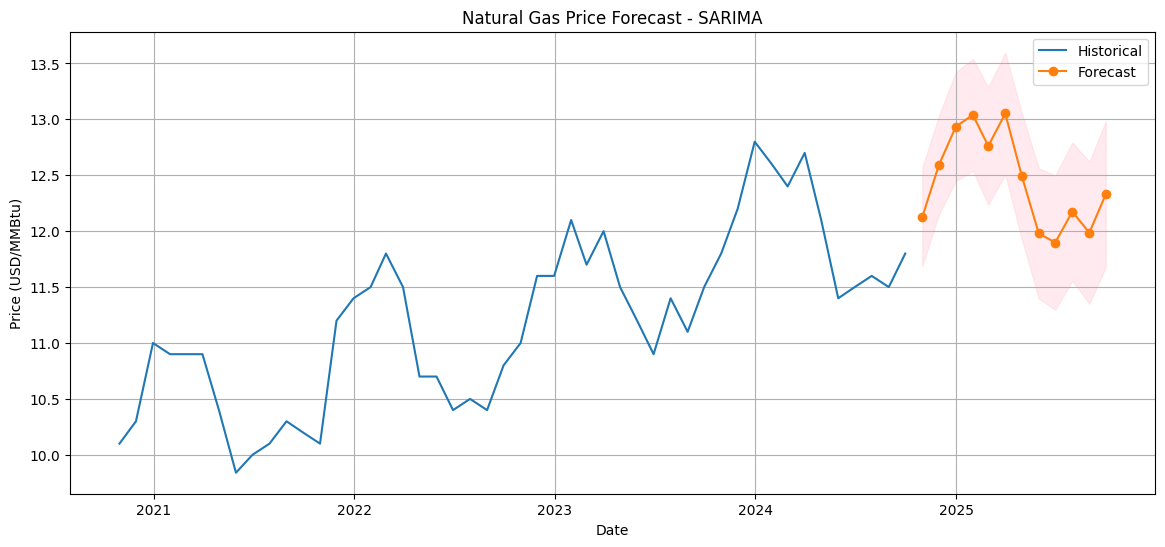


Example 1: Estimate for historical date
2021-06-30: 10.0

Example 2: Estimate for forecasted date
2025-03-31: 13.052295337922942

Example 3: Before data range
2020-01-01: ⚠️ Date is before available data: earliest is 2020-10-31


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from datetime import datetime

# --- LOAD & CLEAN ---
df = pd.read_csv('Nat_Gas.csv')

# Strip whitespace
df.columns = df.columns.str.strip()
df['Dates'] = df['Dates'].astype(str).str.strip()

# Parse correct format
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y', errors='coerce')
df = df.sort_values('Dates').reset_index(drop=True)

# Set Dates as index for SARIMA
df.set_index('Dates', inplace=True)

# --- CHECK STATIONARITY ---
result = adfuller(df['Prices'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("✅ Series is stationary (good for ARIMA)")
else:
    print("⚠️ Series is NOT stationary — using differencing in SARIMA")

# --- FIT SARIMA ---
model = SARIMAX(
    df['Prices'],
    order=(1, 1, 1),             # ARIMA(p,d,q) with differencing
    seasonal_order=(1, 1, 1, 12),  # Seasonal differencing (lag 12 months)
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = model.fit(disp=False)
print(sarima_result.summary())

# --- FORECAST 12 MONTHS AHEAD ---
forecast_steps = 12
forecast = sarima_result.get_forecast(steps=forecast_steps)

# Forecast index
forecast_index = pd.date_range(
    start=df.index[-1] + pd.offsets.MonthEnd(1),
    periods=forecast_steps,
    freq='M'
)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# --- PLOT ---
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Prices'], label='Historical')
plt.plot(forecast_index, forecast_mean, label='Forecast', marker='o')
plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Natural Gas Price Forecast - SARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD/MMBtu)')
plt.legend()
plt.grid(True)
plt.show()

# --- ESTIMATE PRICE FUNCTION ---
def estimate_price(input_date):

     """
    Estimate the price of natural gas for a given date.
    
    If the date is within historical data, return actual or interpolated.
    If the date is in the future (within forecast range), return forecast.
    Otherwise, return warning.
    """
     
    # Parse input date
    input_date = pd.to_datetime(input_date)

    if input_date in df.index:
        # Exact historical date
        return df.loc[input_date, 'Prices']
    elif input_date < df.index.min():
        return f"⚠️ Date is before available data: earliest is {df.index.min().date()}"
    elif input_date > df.index[-1]:
        # Forecasted date: find matching forecast
        if input_date in forecast_index:
            return forecast_mean.loc[input_date]
        else:
            return f"⚠️ Date is beyond forecast window (only {forecast_steps} months ahead)"
    else:
        # Interpolate for date inside range but not exact
        historical = df['Prices'].asfreq('D').interpolate(method='time')
        return historical.loc[input_date]

# --- EXAMPLES ---
print("\nExample 1: Estimate for historical date")
print("2021-06-30:", estimate_price('2021-06-30'))

print("\nExample 2: Estimate for forecasted date")
print("2025-03-31:", estimate_price('2025-03-31'))

print("\nExample 3: Before data range")
print("2020-01-01:", estimate_price('2020-01-01'))


In [16]:
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecast_Price': forecast_mean
})
forecast_df.to_csv('Forecasted_Nat_Gas_Prices.csv', index=False)